# Dec 27th, 2021 (Parcel viz 3D)

**Motivation**: Visualize ROIs for individuals.  Also has functions for visualizing # vox dist. <br>

In [1]:
# HIDE CODE


import os
import sys
import nibabel as nib
import networkx as nx
from time import time
from pprint import pprint
from copy import deepcopy as dc
from os.path import join as pjoin
from myterial import orange, blue_grey
from IPython.display import display, IFrame, HTML
from matplotlib.colors import rgb2hex, to_rgb
import matplotlib.pyplot as plt
import seaborn as sns

# set style & no interpolalation
import matplotlib
matplotlib.rcParams['image.interpolation'] = 'none'
sns.set_style('whitegrid')
%matplotlib inline

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
tmp_dir = pjoin(git_dir, 'jb-Ca-fMRI/tmp')
extras_dir = pjoin(git_dir, 'jb-Ca-fMRI/_extras')
lfr_dir = pjoin(os.environ['HOME'], 'Documents/workspaces/lfr/binary_overlapping')


# GitHub
sys.path.insert(0, pjoin(git_dir, '_Ca-fMRI'))
from register.atlas import make_tree_graph
from register.parcellation import Parcellation
from analysis.hierarchical import Hierarchical
from analysis.fourier import *
from analysis.bootstrap import *
from analysis.svinet import *
from analysis.group import *
from analysis.lfr import *
from utils.render import *
from utils.plotting import *
from model.mouse import Mice
from model.configuration import Config

# warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
# HIDE CODE


def _coronal(key, obj, t1w, figsize=(13.5, 16)):
    slices = range(21, 66, 4)

    fig, axes = create_figure(4, 3, figsize)
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~obj.astype(bool), obj)
        ax.imshow(t1w[..., idx].T, cmap='bone')
        ax.imshow(x2plt[..., idx].T, alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    sup = fig.suptitle(f"{key}  .  .  .  Coronal", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.close()
    
    return fig, sup


def _sagittal(key, obj, t1w, figsize=(13.5, 12)):
    slices = range(2, 48, 4)

    fig, axes = create_figure(4, 3, figsize)
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~obj.astype(bool), obj)
        ax.imshow(t1w[idx], cmap='bone')
        ax.imshow(x2plt[idx], alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    sup = fig.suptitle(f"{key}  .  .  .  Sagittal", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.close()
    
    return fig, sup


def _axial(key, obj, t1w, figsize=(13.5, 13)):
    slices = range(2, 25, 2)

    fig, axes = create_figure(4, 3, figsize)
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~obj.astype(bool), obj)
        ax.imshow(t1w[:, idx, :], cmap='bone')
        ax.imshow(x2plt[:, idx, :], alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    sup = fig.suptitle(f"{key}  .  .  .  Axial", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.close()
    
    return fig, sup

In [3]:
mice = Mice((64, 0, 100), load_parcel=True, full_load=True)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [4]:
cortex = mice.parcel['cortex']
regions = cortex[cortex.nonzero()]
regions = np.unique(regions)
hcl = mice.parcel.decode(regions)

In [5]:
# HIDE CODE


mask_files = sorted([
    str(e) for e in
    pathlib.Path(mice.cfg.masks_dir).rglob('*_cortex.nii.gz*')
])

t1ws = {}
objs = {}
for key, anat in mice.T1w.items():
    file = next(
        f for f in mask_files
        if key in f
    )
    m = mice.mask3d[key].load_ants().numpy()
    obj = ants.image_read(
        pjoin(mice.cfg.masks_dir, file),
        pixeltype='unsigned int',
    )
    objs[key], t1ws[key] = filter_boundaries(
        [obj.numpy(), anat.load_ants().numpy()], m)


dlist = []
for key, obj in objs.items():
    for ll in range(3):
        _regions = mice.parcel.encode(hcl[hcl[:, -1] == ll])
        _sizes = obj[np.isin(obj, _regions)]
        _sizes = collections.Counter(_sizes)
        _sizes = {i: _sizes.get(i, 0) for i in _regions}

        dlist.append({
            'key': [key] * len(_sizes),
            'depth': [ll + 1] * len(_sizes),
            'region': _sizes.keys(),
            'vox': _sizes.values(),
        })

df_vox = pd.DataFrame(merge_dicts(dlist))

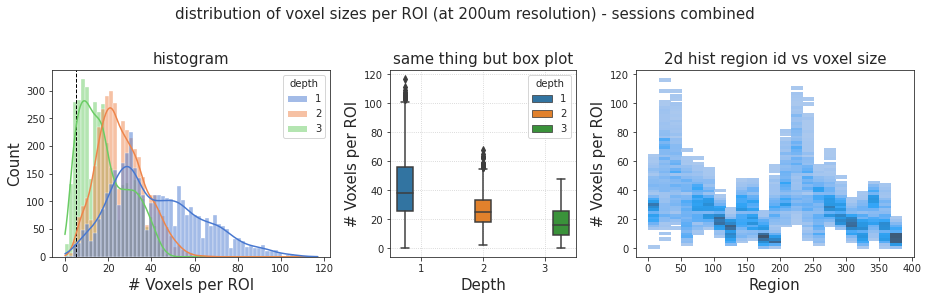

In [6]:
# HIDE CODE


cutoff = 5

fig, axes = create_figure(1, 3, (13, 4), gridspec_kw={'width_ratios': [1.5, 1, 1.5]})

axes[0].axvline(cutoff, color='k', lw=1, ls='--', label=f"cutoff = {cutoff}")
sns.histplot(data=df_vox, x='vox', hue='depth', palette='muted', kde=True, ax=axes[0])
sns.boxplot(data=df_vox, x='depth', y='vox', hue='depth', ax=axes[1])
sns.histplot(data=df_vox, y='vox', x='region', ax=axes[2])
axes[0].set_xlabel('# Voxels per ROI', fontsize=15)
axes[1].set_ylabel('# Voxels per ROI', fontsize=15)
axes[2].set_ylabel('# Voxels per ROI', fontsize=15)
axes[0].set_ylabel('Count', fontsize=15)
axes[1].set_xlabel('Depth', fontsize=15)
axes[2].set_xlabel('Region', fontsize=15)
axes[0].set_title('histogram', fontsize=15)
axes[1].set_title('same thing but box plot', fontsize=15)
axes[2].set_title('2d hist region id vs voxel size', fontsize=15)
axes[1].grid()
fig.suptitle(
    'distribution of voxel sizes per ROI (at 200um resolution) - sessions combined', fontsize=15, y=1.03)
plt.show()

In [7]:
sorted(collections.Counter(df_vox['vox']).most_common())[:10]

[
    (0, 3),
    (1, 21),
    (2, 51),
    (3, 88),
    (4, 155),
    (5, 177),
    (6, 175),
    (7, 205),
    (8, 251),
    (9, 210)
]

In [8]:
(df_vox['vox']  == 0).sum()

3

In [9]:
key = 'sub-SLC01_ses-1'
_df = df_vox.loc[df_vox['key'] == key]
_df

,key,depth,region,vox
0,sub-SLC01_ses-1,1,1,28
1,sub-SLC01_ses-1,1,2,54
2,sub-SLC01_ses-1,1,3,20
3,sub-SLC01_ses-1,1,4,24
4,sub-SLC01_ses-1,1,5,29
...,...,...,...,...
379,sub-SLC01_ses-1,3,380,6
380,sub-SLC01_ses-1,3,381,6
381,sub-SLC01_ses-1,3,382,6
382,sub-SLC01_ses-1,3,383,5


In [10]:
cutoff = 5
small = _df.loc[_df['vox'] < cutoff, 'region'].values
small = np.array(sorted(small))
small_sym = mice.parcel.complement(small)
small

array([ 14,  64, 168, 174, 181, 185, 188, 189, 192, 325, 366, 373, 376])

In [11]:
small_sym

array([ 14,  64, 133, 168, 174, 181, 184, 185, 188, 189, 192, 206, 256,
       325, 360, 366, 373, 376, 377, 380, 381, 384], dtype=uint32)

In [12]:
sorted(set(small_sym).difference(small))

[133, 184, 206, 256, 360, 377, 380, 381, 384]

In [13]:
_df.loc[_df['region'].isin(small_sym)]

,key,depth,region,vox
13,sub-SLC01_ses-1,1,14,0
63,sub-SLC01_ses-1,1,64,4
77,sub-SLC01_ses-1,1,206,51
127,sub-SLC01_ses-1,1,256,7
260,sub-SLC01_ses-1,3,133,5
295,sub-SLC01_ses-1,3,168,4
301,sub-SLC01_ses-1,3,174,3
308,sub-SLC01_ses-1,3,181,1
311,sub-SLC01_ses-1,3,184,6
312,sub-SLC01_ses-1,3,185,4


<AxesSubplot:xlabel='vox', ylabel='Count'>

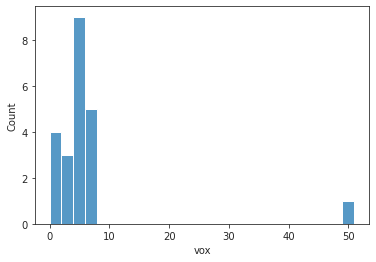

In [14]:
sns.histplot(_df.loc[_df['region'].isin(small_sym), 'vox'])

In [15]:
len(small), len(small_sym)

(13, 22)

In [16]:
mice.parcel.complement([206])

array([ 14, 206], dtype=uint32)

In [17]:
collections.Counter(mice.parcel.decode(small)[:, -1])

Counter({0: 2, 2: 11})

In [18]:
x = objs[key].copy().astype(float)
x[~np.isin(x, small)] = np.nan

x_sym = objs[key].copy().astype(float)
x_sym[~np.isin(x_sym, small_sym)] = np.nan

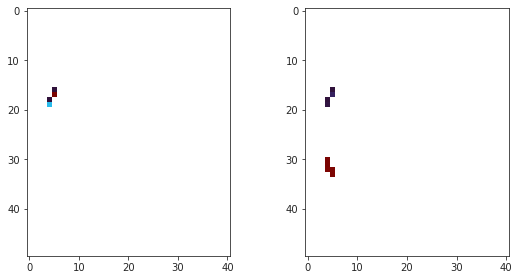

In [19]:
fig, axes = create_figure(1, 2, (8, 4))
axes[0].imshow(x[..., 27], cmap='turbo')
axes[1].imshow(x_sym[..., 27], cmap='turbo')
plt.show()

In [20]:
_t1w = mice.T1w[key].load_ants()
_t1w

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (64, 64, 78)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [21]:
ants.image_write(_t1w, pjoin(tmp_dir, f'T1w_{key}.nii.gz'))

In [22]:
from register.register import reset_ants_img
img = reset_ants_img(
    img=x,
    spacing=_t1w.spacing,
    origin=_t1w.origin,
    dtype='float32',
    use_um=False,
)
img_sym = reset_ants_img(
    img=x_sym,
    spacing=_t1w.spacing,
    origin=_t1w.origin,
    dtype='float32',
    use_um=False,
)
img

ANTsImage (RAI)
         Pixel Type : float (float32)
         Components : 1
         Dimensions : (50, 41, 75)
         Spacing    : (0.2, 0.2, 0.2)
         Origin     : (6.4, -6.2, -7.8)
         Direction  : [1. 0. 0. 0. 1. 0. 0. 0. 1.]

In [23]:
ants.image_write(img, pjoin(tmp_dir, f'cutoff-{cutoff}_{key}.nii.gz'))
ants.image_write(img_sym, pjoin(tmp_dir, f'cutoff-{cutoff}_{key}_sym.nii.gz'))

## Remove stats

In [21]:
cutoff = 5
remove = []
remove_sym = []

for key in df_vox['key'].unique():
    _df = df_vox.loc[df_vox['key'] == key]
    small = _df.loc[_df['vox'] < cutoff, 'region'].values
    small = np.array(sorted(small))
    small_sym = mice.parcel.complement(small)

    remove.extend(list(small))
    remove_sym.extend(list(small_sym))
    
remove = collections.Counter(remove)
remove_sym = collections.Counter(remove_sym)

In [24]:
remove.most_common()

[
    (373, 30),
    (181, 29),
    (325, 25),
    (174, 22),
    (188, 21),
    (133, 20),
    (380, 20),
    (191, 16),
    (189, 15),
    (384, 14),
    (192, 13),
    (366, 13),
    (383, 13),
    (381, 10),
    (175, 7),
    (168, 6),
    (64, 5),
    (360, 5),
    (256, 5),
    (127, 4),
    (319, 4),
    (185, 3),
    (376, 3),
    (128, 3),
    (320, 2),
    (184, 2),
    (170, 2),
    (14, 1),
    (367, 1),
    (312, 1),
    (176, 1),
    (362, 1),
    (183, 1)
]

In [25]:
remove_sym.most_common()

[
    (181, 30),
    (373, 30),
    (133, 28),
    (188, 28),
    (325, 28),
    (380, 28),
    (174, 27),
    (366, 27),
    (191, 23),
    (383, 23),
    (192, 22),
    (384, 22),
    (189, 21),
    (381, 21),
    (64, 10),
    (256, 10),
    (168, 9),
    (360, 9),
    (175, 8),
    (367, 8),
    (127, 6),
    (319, 6),
    (184, 5),
    (376, 5),
    (128, 4),
    (320, 4),
    (185, 3),
    (377, 3),
    (170, 3),
    (362, 3),
    (14, 1),
    (206, 1),
    (120, 1),
    (312, 1),
    (176, 1),
    (368, 1),
    (183, 1),
    (375, 1)
]

Text(0.5, 0, 'num sessions from which the ROI was removed')

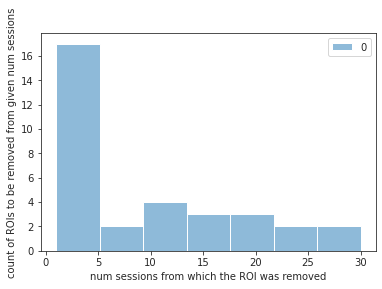

In [31]:
sns.histplot(remove.values())
plt.ylabel('count of ROIs to be removed from given num sessions')
plt.xlabel('num sessions from which the ROI was removed')

## All in 1 PDF

### Get random cmap

In [9]:
rng = get_rng()
num = len(mice.parcel['regions-cortex'])
colors = (
    rng.choice(256, size=num) / 256,
    rng.choice(256, size=num) / 256,
    rng.choice(256, size=num) / 256,
)
colors = list(zip(*colors))
colors = [rgb2hex(c) for c in colors]
cmap = make_cmap(
    ramp_colors=colors,
    name='random_cmap',
    n_colors=num,
    show=False,
)

In [10]:
for key, obj in tqdm(objs.items()):
    save_file = pjoin(tmp_dir, 'ROI_plots', f'ROIs_{key}.pdf')
    f1, s1 = _coronal(key, obj, t1ws[key])
    f2, s2 = _sagittal(key, obj, t1ws[key])
    f3, s3 = _axial(key, obj, t1ws[key])
    save_fig(
        fig=[f1, f2, f3],
        sup=[s1, s2, s3],
        save_file=save_file,
        display=False,
        multi=True,
    )

  0%|          | 0/30 [00:00<?, ?it/s]

### Coronal

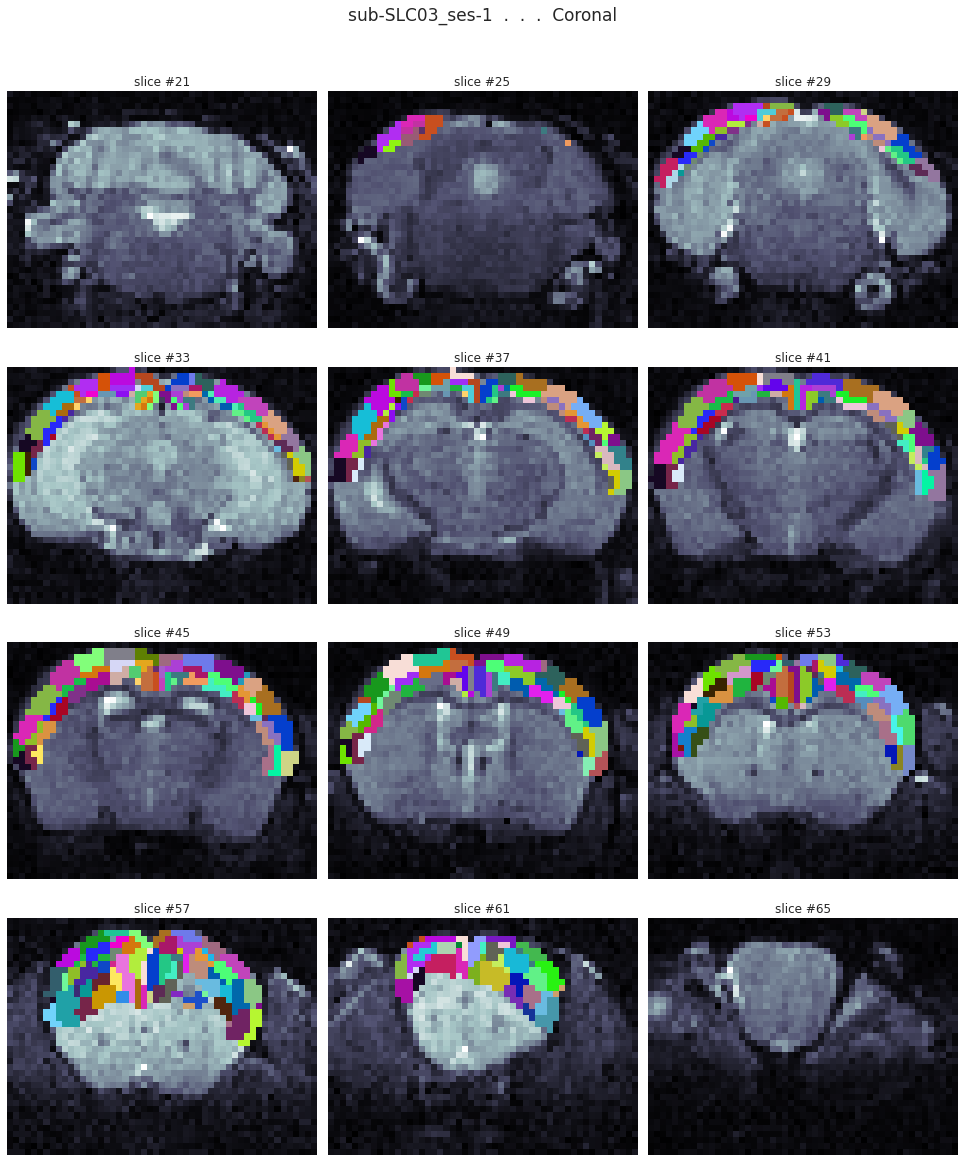

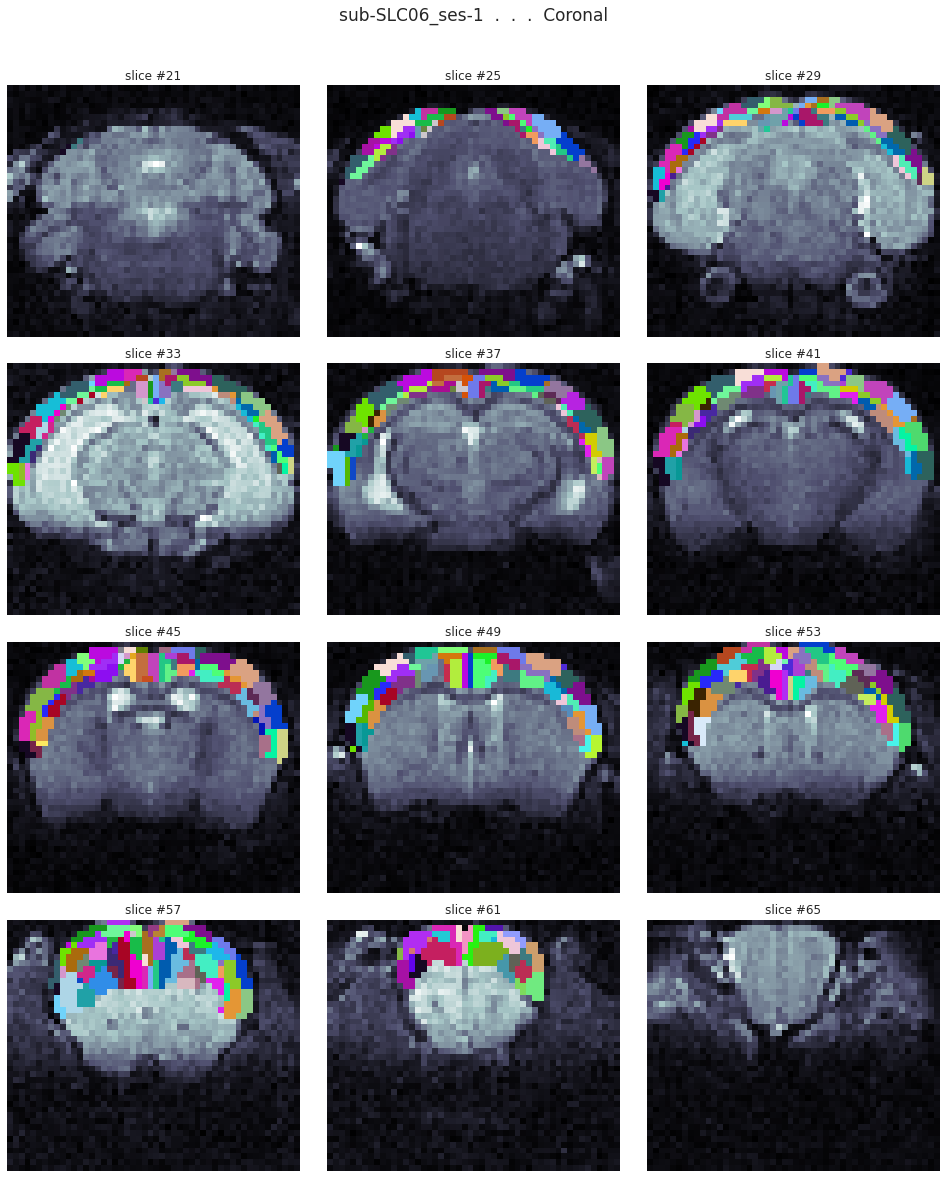

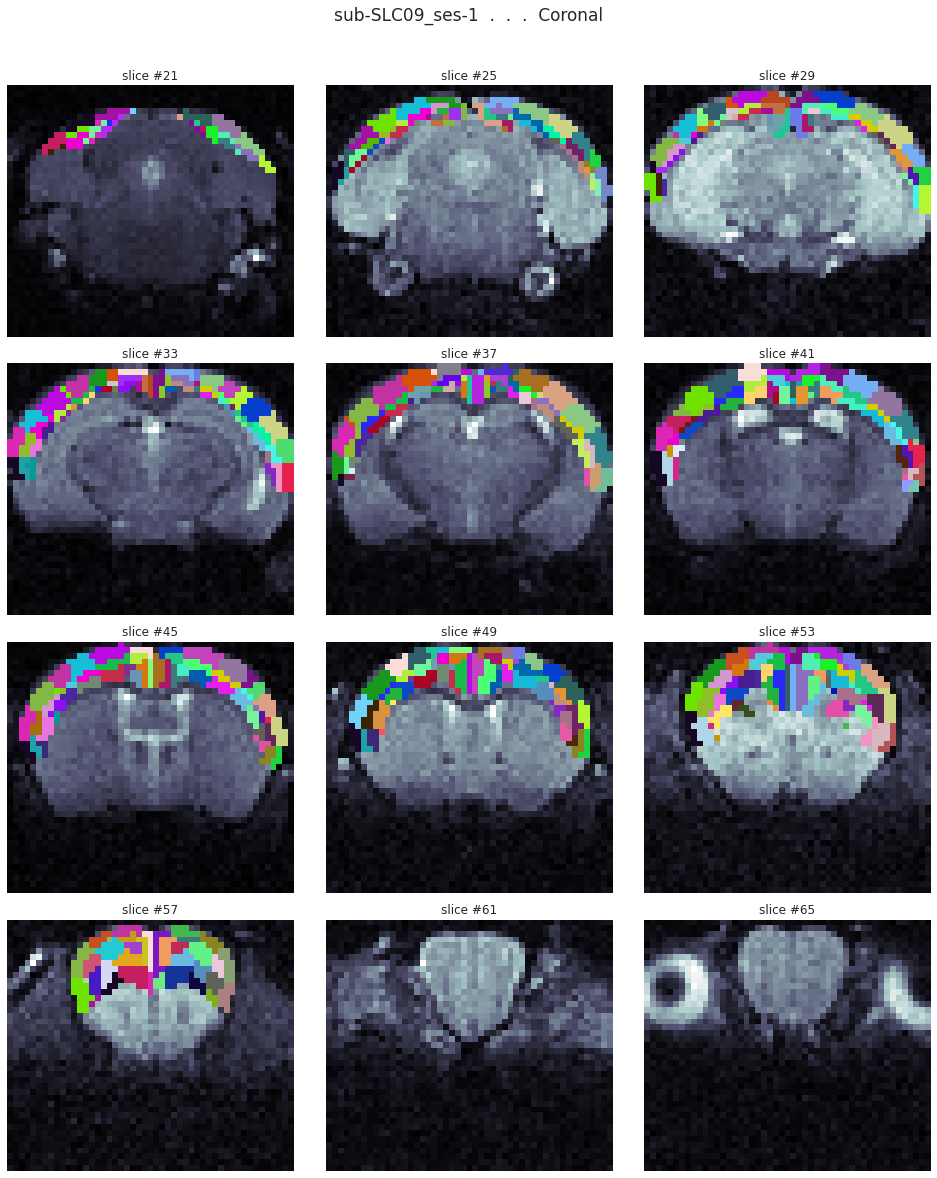

In [26]:
for key in ['sub-SLC03_ses-1', 'sub-SLC06_ses-1', 'sub-SLC09_ses-1']:
    slices = range(21, 66, 4) # np.linspace(22, 65, 16)
    # slices = np.round(slices).astype(int)

    fig, axes = create_figure(4, 3, (13.5, 16))
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~objs[key].astype(bool), objs[key])
        ax.imshow(t1ws[key][..., idx].T, cmap='bone')
        ax.imshow(x2plt[..., idx].T, alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    fig.suptitle(f"{key}  .  .  .  Coronal", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.show()

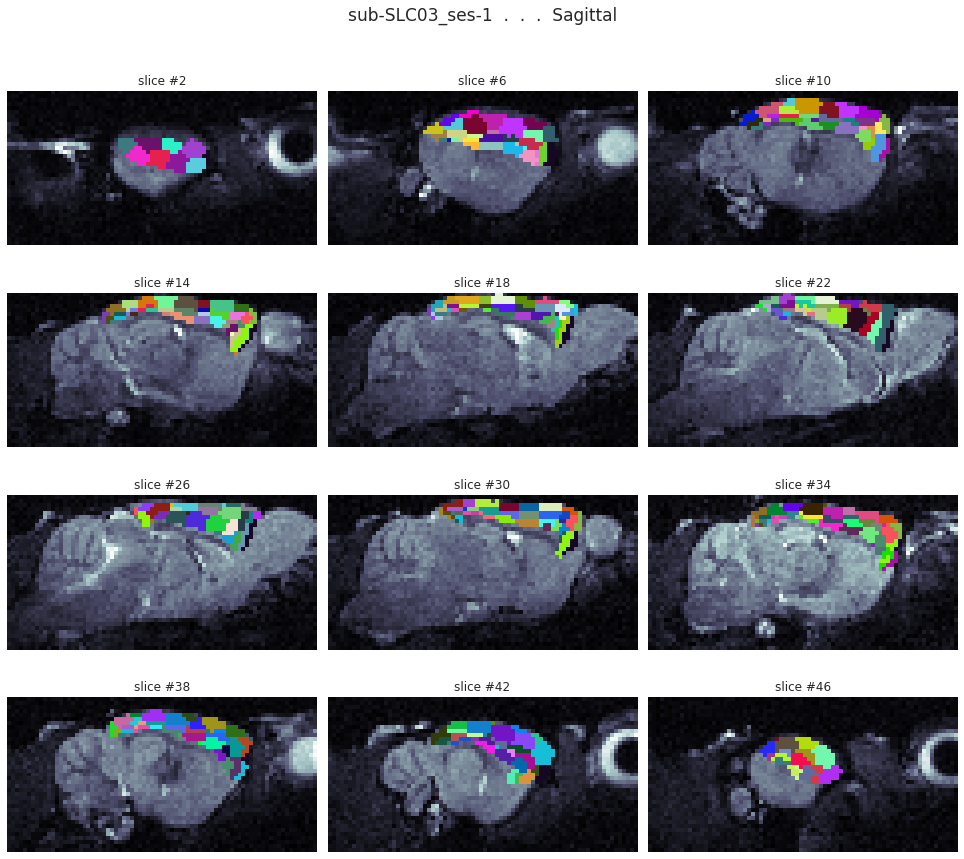

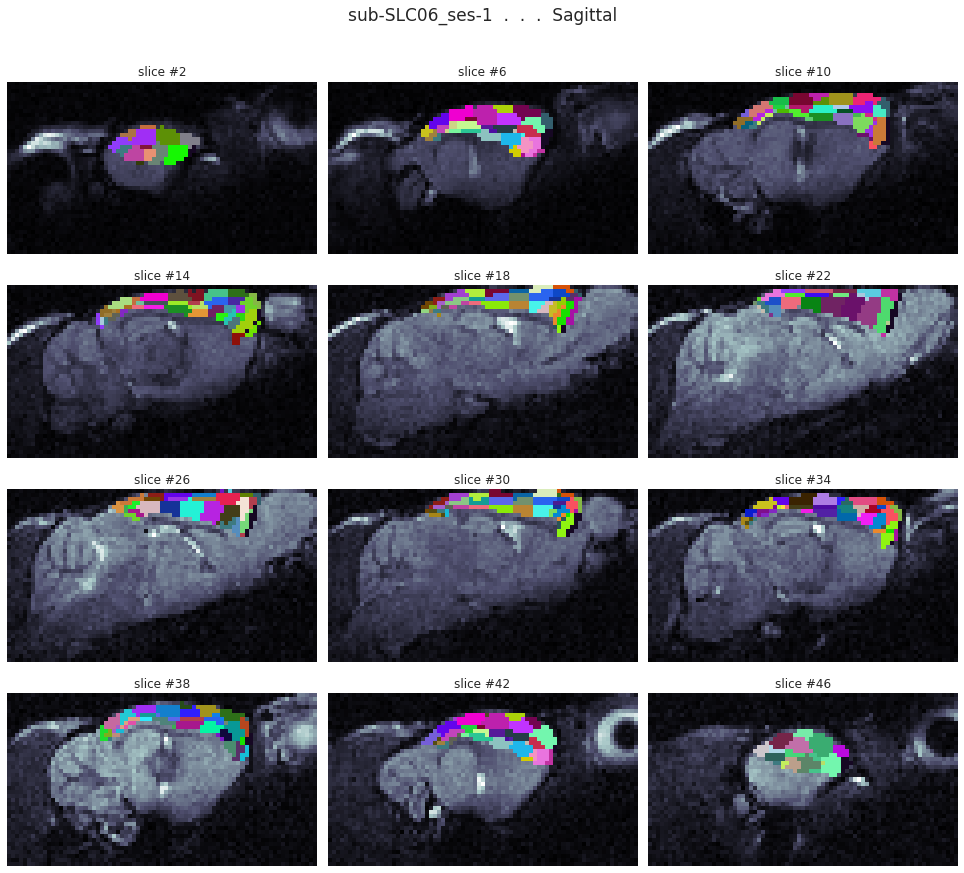

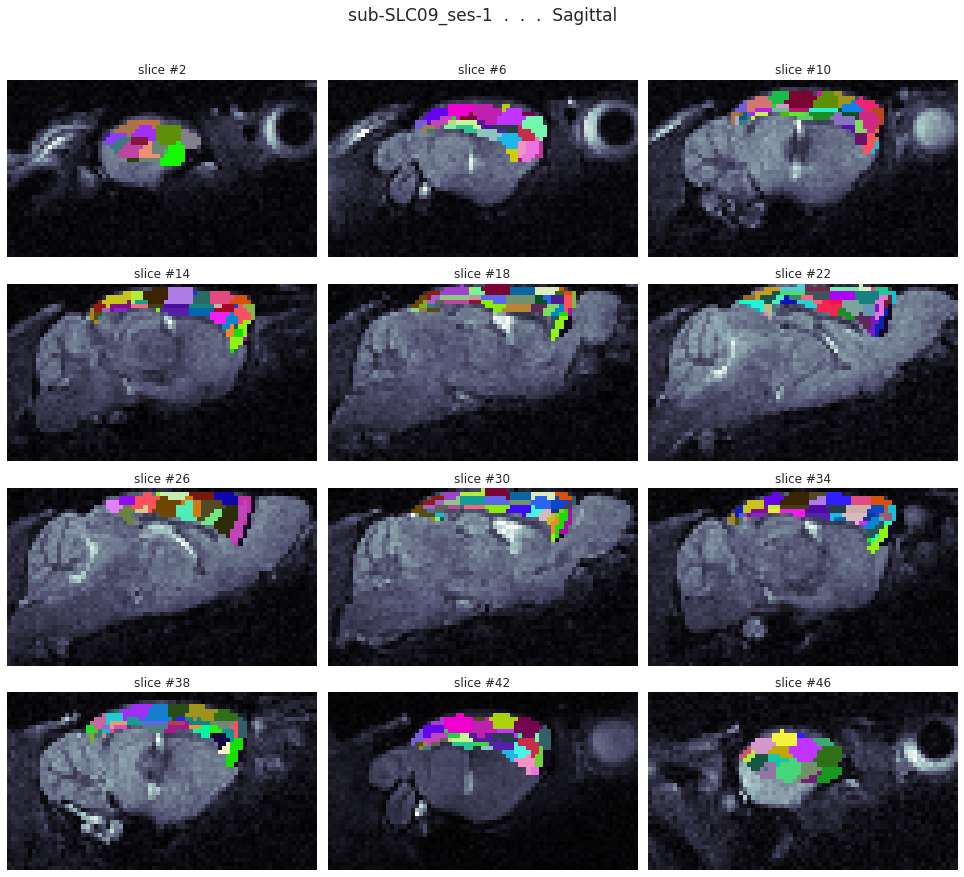

In [28]:
for key in ['sub-SLC03_ses-1', 'sub-SLC06_ses-1', 'sub-SLC09_ses-1']:
    slices = range(2, 48, 4) #np.linspace(2, 47, 12)

    fig, axes = create_figure(4, 3, (13.5, 12))
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~objs[key].astype(bool), objs[key])
        ax.imshow(t1ws[key][idx], cmap='bone')
        ax.imshow(x2plt[idx], alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    fig.suptitle(f"{key}  .  .  .  Sagittal", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.show()

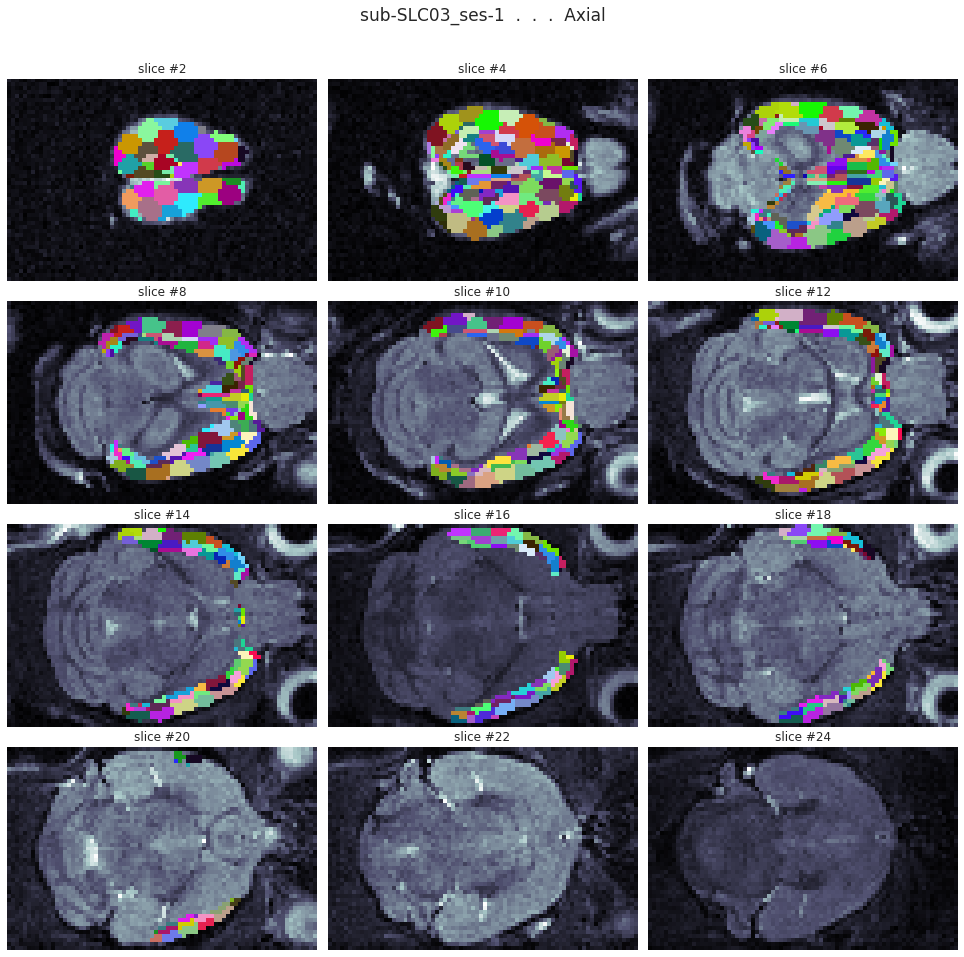

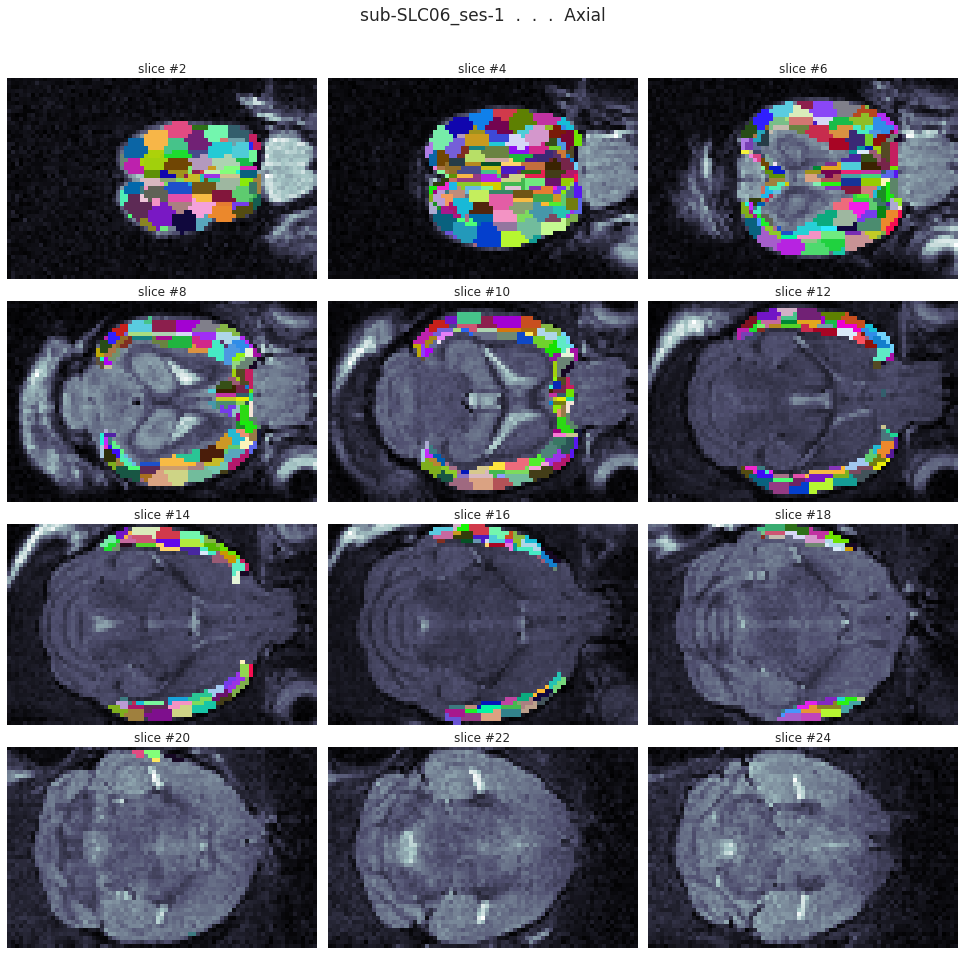

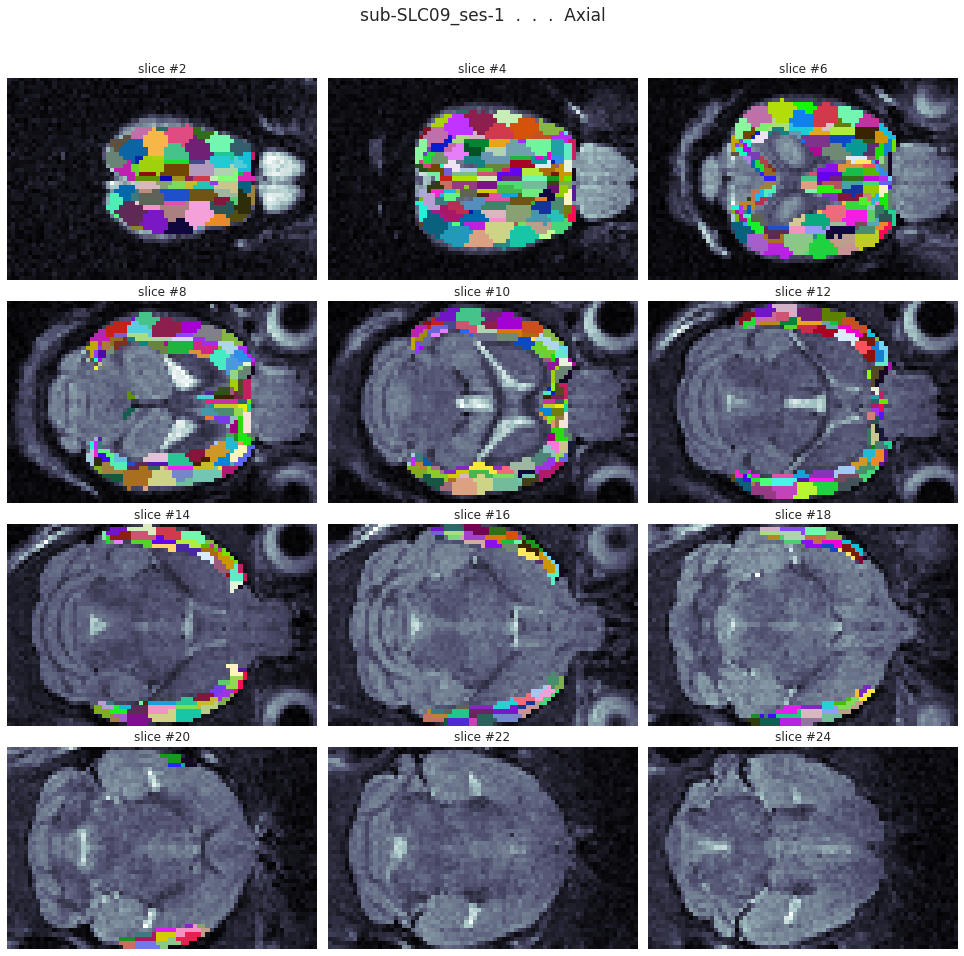

In [29]:
for key in ['sub-SLC03_ses-1', 'sub-SLC06_ses-1', 'sub-SLC09_ses-1']:
    slices = range(2, 25, 2)

    fig, axes = create_figure(4, 3, (13.5, 13))
    for i, idx in enumerate(slices):
        ax = axes.flat[i]
        x2plt = np.ma.masked_where(~objs[key].astype(bool), objs[key])
        ax.imshow(t1ws[key][:, idx, :], cmap='bone')
        ax.imshow(x2plt[:, idx, :], alpha=1.0, cmap=cmap)
        ax.set_title(f"slice #{idx}")
    fig.suptitle(f"{key}  .  .  .  Axial", fontsize=17, y=1.02)
    remove_ticks(axes)
    plt.show()

In [ ]:
slices = np.linspace(1, 25, 12)
slices = np.round(slices).astype(int)

fig, axes = create_figure(4, 3, (13.5, 12.5))
for i, idx in enumerate(slices):
    ax = axes.flat[i]
    x2plt = np.ma.masked_where(~objs[key].astype(bool), objs[key])
    ax.imshow(t1ws[key][:, idx, :], cmap='bone')
    ax.imshow(x2plt[:, idx, :], alpha=1.0, cmap=cmap)
    ax.set_title(f"slice #{idx}")
remove_ticks(axes)
plt.show()

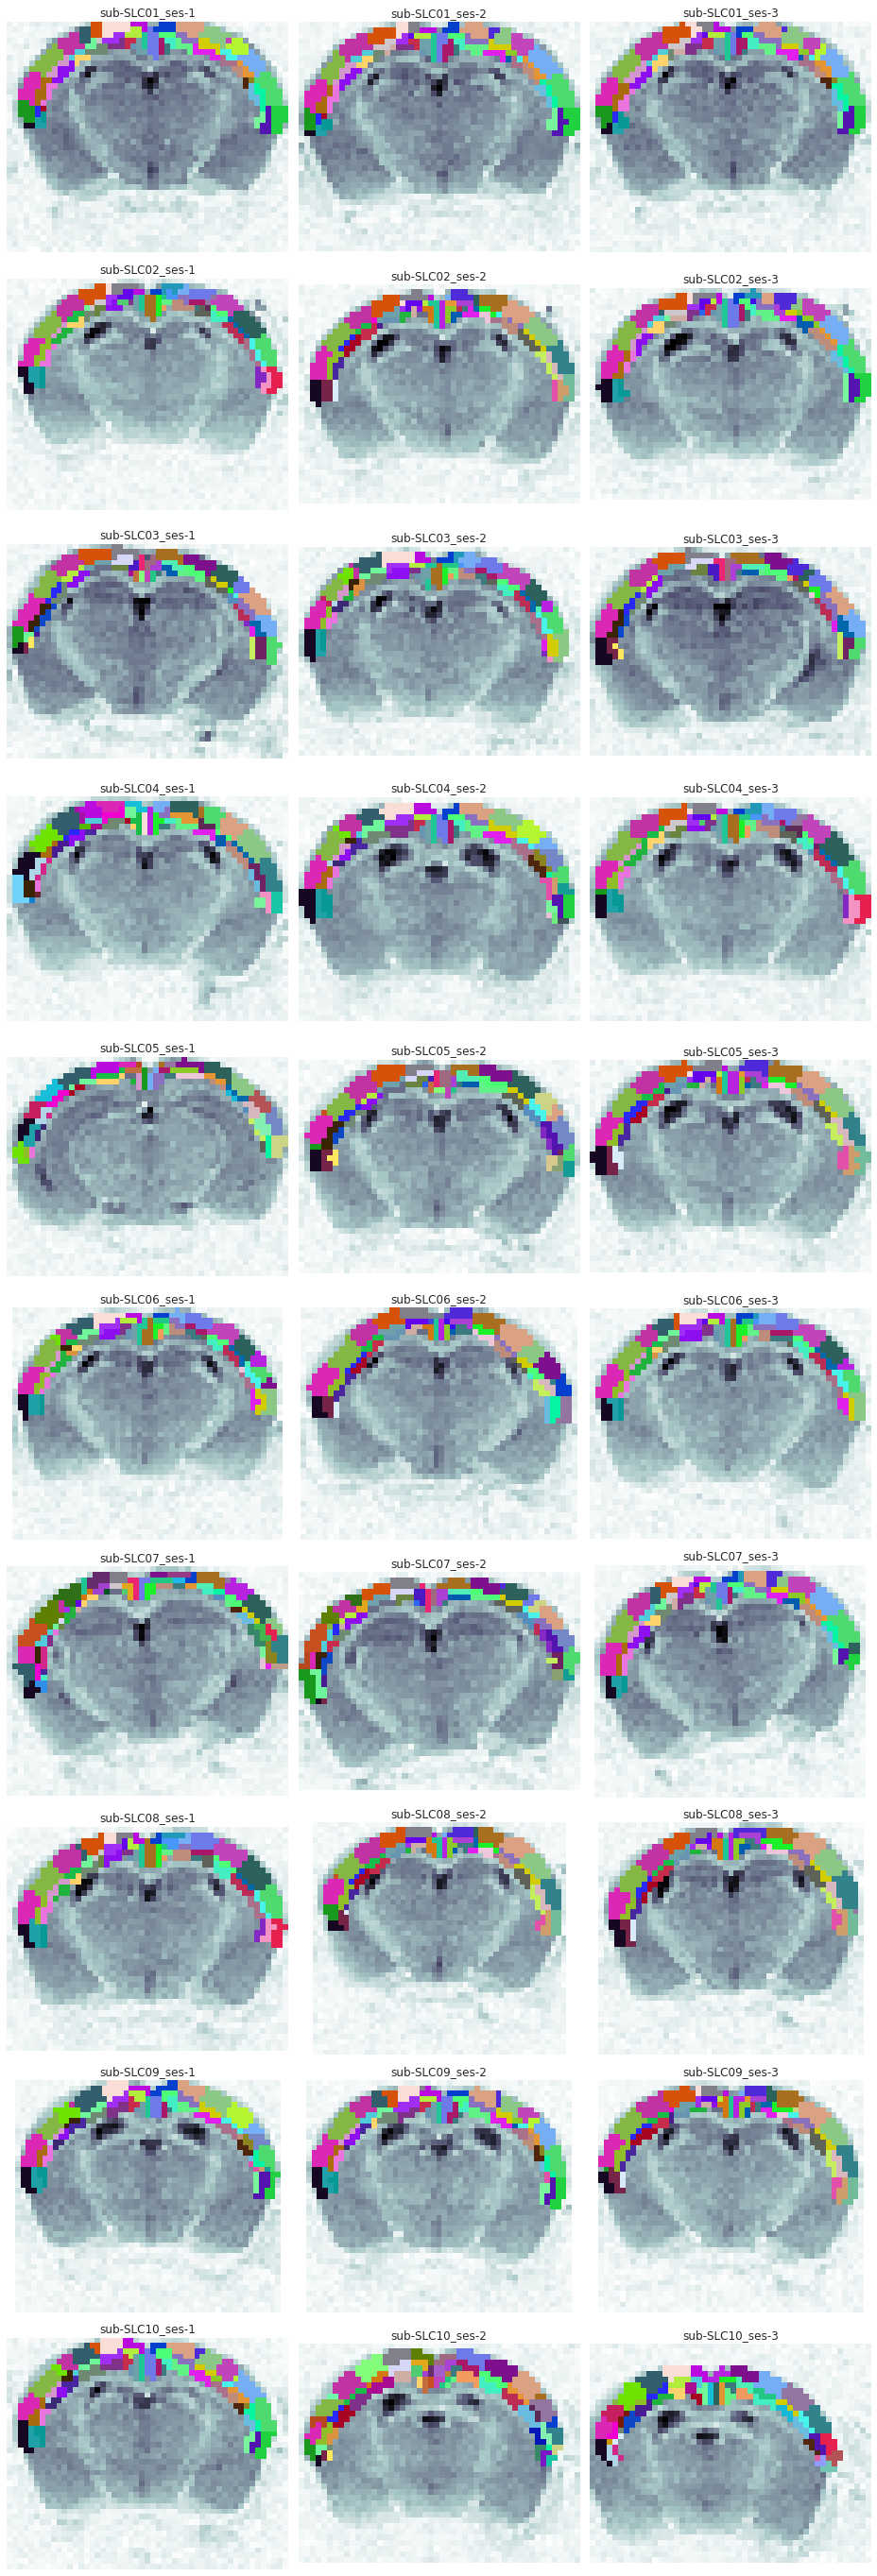

In [69]:
# HIDE CODE


fig, axes = create_figure(10, 3, (13, 38))
for ax, (key, obj) in zip(axes.flat, objs.items()):
    x2plt = np.ma.masked_where(~obj.astype(bool), obj)
    ax.imshow(t1ws[key][..., 40].T, cmap='bone_r')
    ax.imshow(x2plt[..., 40].T, alpha=1.0, cmap=cmap)
    ax.set_title(key)
remove_ticks(axes)
plt.show()

### Sagittal

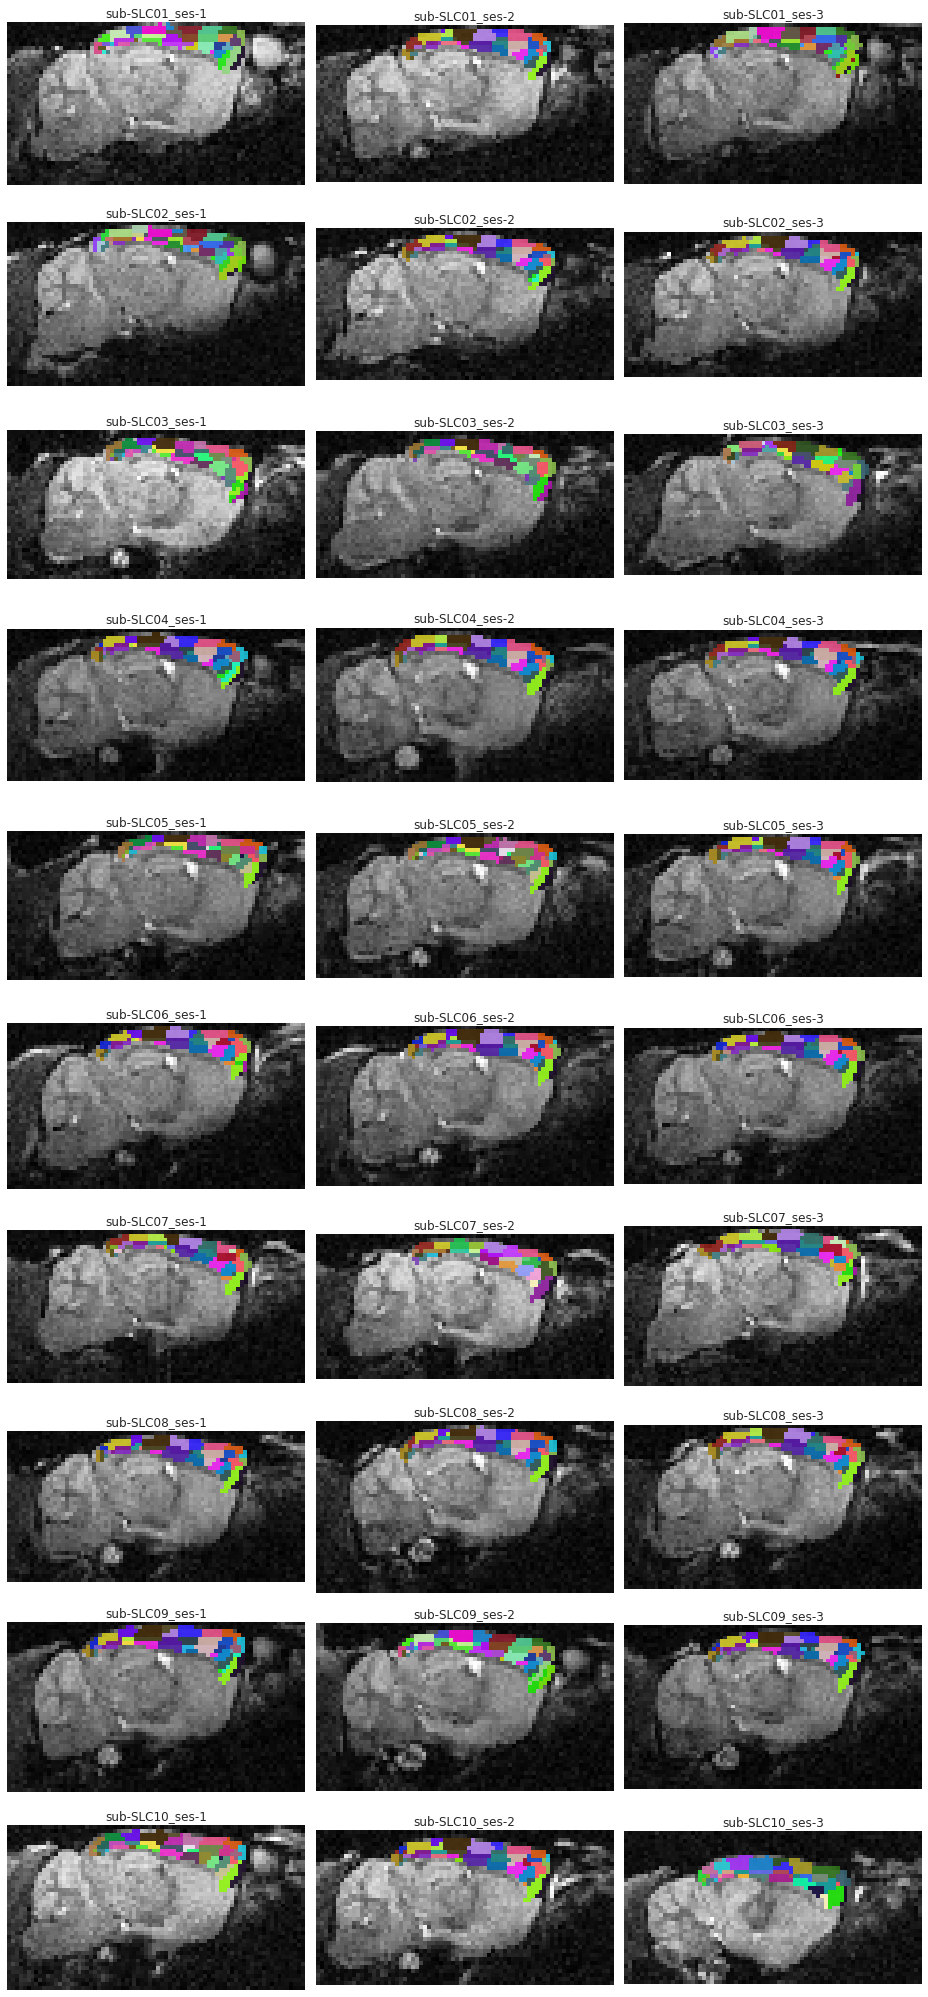

In [65]:
# HIDE CODE


fig, axes = create_figure(10, 3, (13, 28))
for ax, (key, obj) in zip(axes.flat, objs.items()):
    x2plt = np.ma.masked_where(~obj.astype(bool), obj)
    ax.imshow(t1ws[key][34], cmap='Greys_r')
    ax.imshow(x2plt[34], alpha=0.9, cmap=cmap)
    ax.set_title(key)
remove_ticks(axes)
plt.show()

### Axial

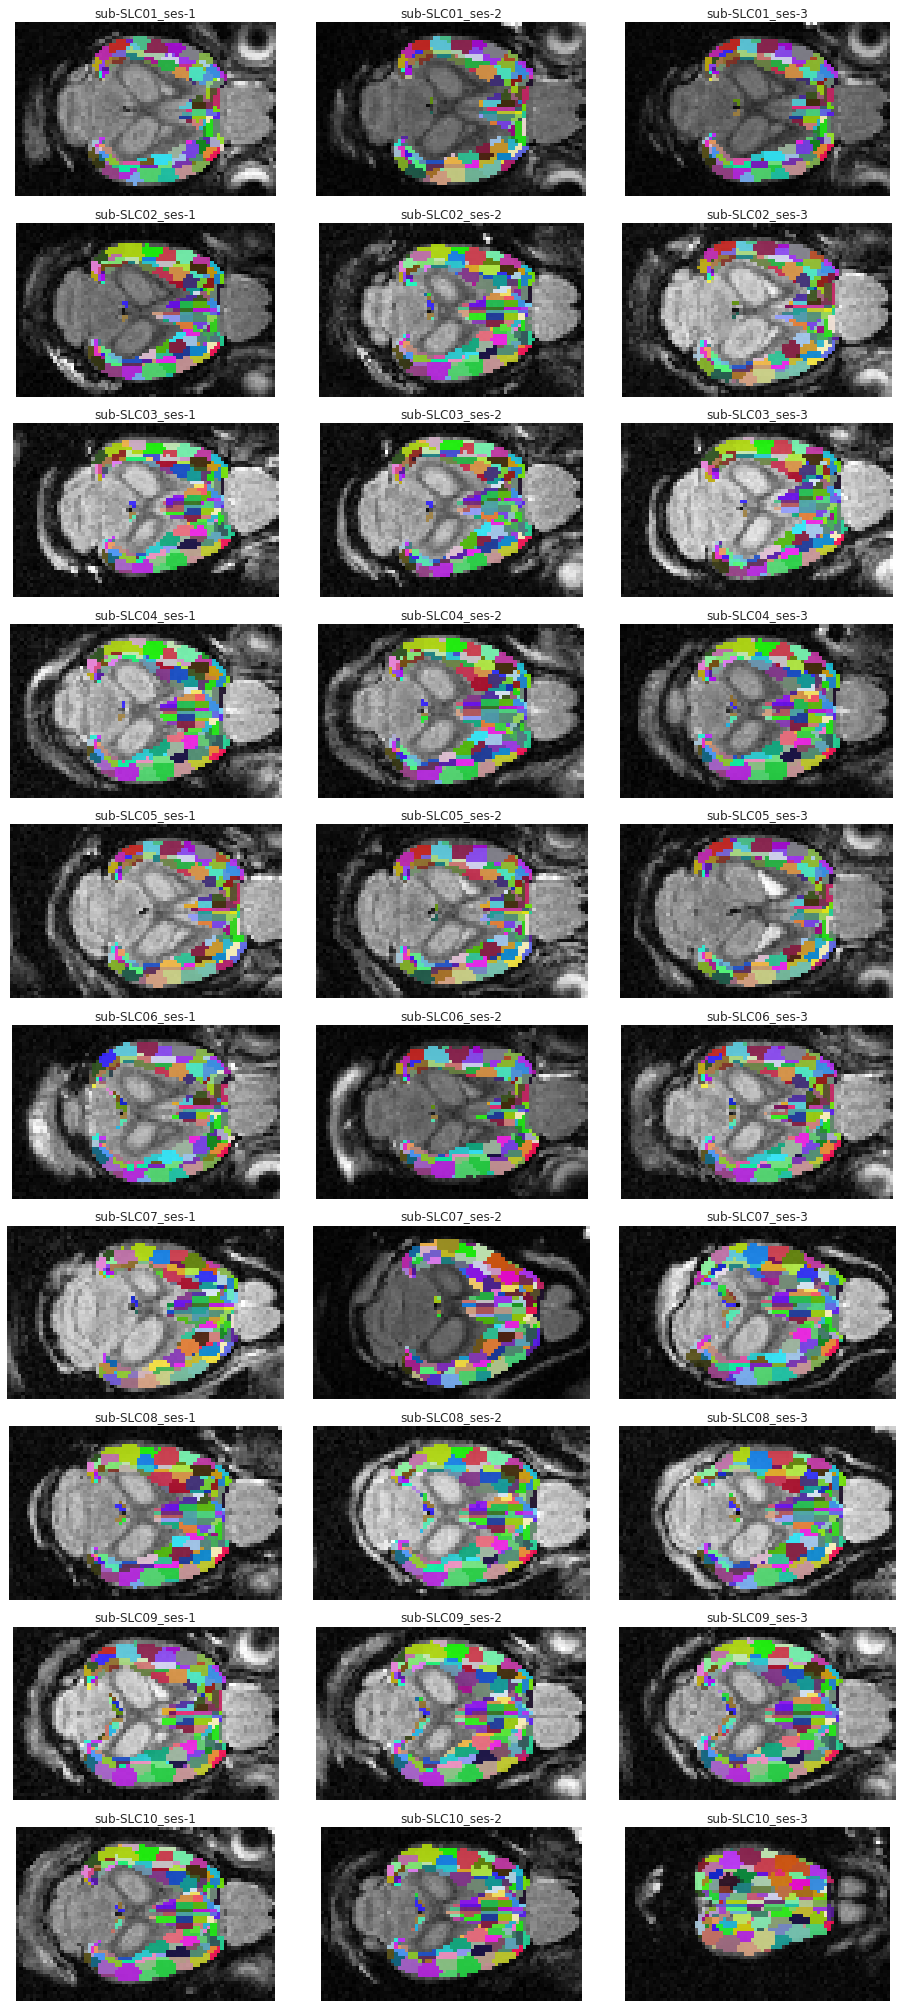

In [66]:
# HIDE CODE


fig, axes = create_figure(10, 3, (13, 28))
for ax, (key, obj) in zip(axes.flat, objs.items()):
    x2plt = np.ma.masked_where(~obj.astype(bool), obj)
    ax.imshow(t1ws[key][:, 7, :], cmap='Greys_r')
    ax.imshow(x2plt[:, 7, :], alpha=0.9, cmap=cmap)
    ax.set_title(key)
remove_ticks(axes)
plt.show()

### Distribution of ROI sizes (individual space)

In [12]:
# HIDE CODE


dlist = []
for key, obj in objs.items():
    for ll in range(3):
        _regions = mice.parcel.encode(hcl[hcl[:, -1] == ll])
        _sizes = obj[np.isin(obj, _regions)]
        _sizes = collections.Counter(_sizes)

        dlist.append({
            'key': [key] * len(_sizes),
            'depth': [ll + 1] * len(_sizes),
            'region': _sizes.keys(),
            'vox': _sizes.values(),
        })

df_vox = pd.DataFrame(merge_dicts(dlist))

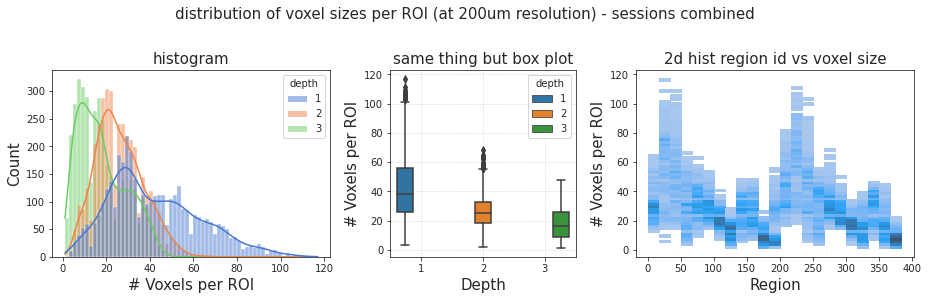

In [13]:
# HIDE CODE


fig, axes = create_figure(1, 3, (13, 4), gridspec_kw={'width_ratios': [1.5, 1, 1.5]})

sns.histplot(data=df_vox, x='vox', hue='depth', palette='muted', kde=True, ax=axes[0])
sns.boxplot(data=df_vox, x='depth', y='vox', hue='depth', ax=axes[1])
sns.histplot(data=df_vox, y='vox', x='region', ax=axes[2])
axes[0].set_xlabel('# Voxels per ROI', fontsize=15)
axes[1].set_ylabel('# Voxels per ROI', fontsize=15)
axes[2].set_ylabel('# Voxels per ROI', fontsize=15)
axes[0].set_ylabel('Count', fontsize=15)
axes[1].set_xlabel('Depth', fontsize=15)
axes[2].set_xlabel('Region', fontsize=15)
axes[0].set_title('histogram', fontsize=15)
axes[1].set_title('same thing but box plot', fontsize=15)
axes[2].set_title('2d hist region id vs voxel size', fontsize=15)
axes[1].grid()
fig.suptitle(
    'distribution of voxel sizes per ROI (at 200um resolution) - sessions combined', fontsize=15, y=1.03)
plt.show()

In [14]:
df_vox.loc[df_vox['vox'] < 2]

,key,depth,region,vox
318,sub-SLC01_ses-1,3,181,1
325,sub-SLC01_ses-1,3,373,1
1106,sub-SLC01_ses-3,3,325,1
1466,sub-SLC02_ses-1,3,174,1
1476,sub-SLC02_ses-1,3,373,1
2237,sub-SLC02_ses-3,3,181,1
3005,sub-SLC03_ses-2,3,181,1
3039,sub-SLC03_ses-2,3,380,1
3389,sub-SLC03_ses-3,3,181,1
4156,sub-SLC04_ses-2,3,181,1


[
    (1, 21),
    (2, 51),
    (3, 88),
    (4, 155),
    (5, 177),
    (6, 175),
    (7, 205),
    (8, 251),
    (9, 210),
    (10, 235),
    (11, 237),
    (12, 236),
    (13, 221),
    (14, 266),
    (15, 263),
    (16, 301),
    (17, 300),
    (18, 329),
    (19, 304),
    (20, 307)
]

## Render

Here I've embedded an interactive 3D rendering of ROIs.

In [16]:
width=800
height=700

### Full ROIs (columns and layers)

In [17]:
file = f"../../_extras/columnar_n64*0_k384.html"
IFrame(file, width=width, height=height)

### Columns only (right hemisphere)

In [18]:
file = f"../../_extras/columns_n64*0_k64.html"
IFrame(file, width=width, height=height)

### Layers only (3 depths)

In [19]:
file = f"../../_extras/layers_n64*0_k3.html"
IFrame(file, width=width, height=height)

## Transform masks (ignore)

In [2]:
from register.register import Register

mice = Mice((64, 0, 100), load_parcel=True, load_allen=True)
reg = Register(mice)

ROI lookup not found, time to run organize_func() . . .

combine metadata not found, time to run cat_data() . . .

In [3]:
reg.register_anat(True)

registering anat sub-SLC10_ses-3: 100%|██████████| 30/30 [11:27<00:00, 22.93s/it]
